In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_doge_lstm_sequences(raw_input_file="E:\\DOGE-USD.csv", 
                               output_filename="doge_lstm_pytorch_data.npz",
                               lookback_window=30): # Look back 30 days
    """
    Prepares Dogecoin DAILY data for a standard LSTM model. It handles the specific
    'Date' column format and uses only raw OHLCV features.
    """
    print("--- Starting Data Preparation for Dogecoin Standard LSTM ---")
    
    try:
        df = pd.read_csv(raw_input_file)
        print(f"1. Reading raw Dogecoin data from '{raw_input_file}' ({len(df)} rows)...")
    except FileNotFoundError:
        print(f"ERROR: Raw input file '{raw_input_file}' not found.")
        return

    # --- Data Cleaning and Formatting for Daily Data ---
    print("2. Adapting to Dogecoin daily data format...")
    # Convert 'Date' string to a proper datetime object
    df['Date'] = pd.to_datetime(df['Date'])
    # Sort by date to ensure chronological order
    df.sort_values('Date', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # --- Robust Data Cleaning (same as Solana) ---
    print("3. Creating all target and feature columns for robust NaN handling...")
    # Create targets
    prediction_horizons = {
        "Target_1_Day_Pct_Change": 1,
        "Target_7_Day_Pct_Change": 7,
        "Target_30_Day_Pct_Change": 30,
        "Target_90_Day_Pct_Change": 90
    }
    for name, horizon in prediction_horizons.items():
        future_price = df['Open'].shift(-horizon)
        df[name] = ((future_price - df['Close']) / df['Close']) * 100

    # Create a temporary SMA to identify all rows with potential NaN values
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    
    # Drop ALL rows with ANY NaN values to get a clean dataset
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # --- Select Final Features for Standard LSTM ---
    print("4. Selecting final features for the Standard LSTM model...")
    features_to_use = ['Open', 'High', 'Low', 'Close', 'Volume']
    target_cols = list(prediction_horizons.keys())

    df_features = df[features_to_use]
    df_targets = df[target_cols]

    print("5. Scaling feature data...")
    feature_scaler = MinMaxScaler()
    scaled_features = feature_scaler.fit_transform(df_features.astype('float32'))

    print(f"6. Creating sequences with a {lookback_window}-day lookback...")
    X, y = [], []
    for i in range(lookback_window, len(scaled_features)):
        X.append(scaled_features[i - lookback_window:i])
        y.append(df_targets.iloc[i].values)

    X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
    
    print(f"   Created {len(X)} sequences. Shape: {X.shape}")

    print("7. Splitting and saving final data...")
    n_total = len(X)
    n_train = int(n_total * 0.85)
    X_train, y_train = X[:n_train], y[:n_train]
    X_test, y_test = X[n_train:], y[n_train:]

    np.savez_compressed(output_filename,
        X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
        feature_scaler=np.array([feature_scaler]), target_cols=np.array(target_cols)
    )
    print(f"\n--- SUCCESS: Dogecoin Standard LSTM data preparation complete. ---")

if __name__ == "__main__":
    create_doge_lstm_sequences()

--- Starting Data Preparation for Dogecoin Standard LSTM ---
1. Reading raw Dogecoin data from 'E:\DOGE-USD.csv' (2335 rows)...
2. Adapting to Dogecoin daily data format...
3. Creating all target and feature columns for robust NaN handling...
4. Selecting final features for the Standard LSTM model...
5. Scaling feature data...
6. Creating sequences with a 30-day lookback...
   Created 2165 sequences. Shape: (2165, 30, 5)
7. Splitting and saving final data...

--- SUCCESS: Dogecoin Standard LSTM data preparation complete. ---


In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error

# Configuration Dictionary
config = {
    "batch_size": 16,
    "hidden_units": 40,
    "learning_rate": 0.001,
    "epochs": 100,
    "patience": 10,
}

# The model and early stopper classes are perfectly reusable
class LSTMModel(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=hidden_units, out_features=25)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

class EarlyStopper:
    def __init__(self, patience, model_path):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.model_path = model_path

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.model_path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"--- Early stopping triggered after {self.patience} epochs. ---")
                return True
        return False

# Main Training and Evaluation Function
def main():
    print("--- Starting Dogecoin PyTorch Standard LSTM Model Training ---")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"1. Using device: {device}")
    
    # --- FILENAMES FOR DOGECOIN ---
    data_filename = "doge_lstm_pytorch_data.npz"
    model_path = "doge_lstm_pytorch_model.pth"

    try:
        with np.load(data_filename, allow_pickle=True) as data:
            X_train, y_train, X_test, y_test, target_cols = data['X_train'], data['y_train'], data['X_test'], data['y_test'], data['target_cols']
    except FileNotFoundError:
        print(f"ERROR: Data file '{data_filename}' not found. Please run the preparation script first.")
        return

    val_split = int(len(X_train) * 0.85)
    X_train, X_val = X_train[:val_split], X_train[val_split:]
    y_train, y_val = y_train[:val_split], y_train[val_split:]

    train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()), batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float()), batch_size=config["batch_size"])

    model = LSTMModel(X_train.shape[2], config["hidden_units"], y_train.shape[1]).to(device)
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
    early_stopper = EarlyStopper(patience=config["patience"], model_path=model_path)

    print(f"2. Starting training for up to {config['epochs']} epochs...")
    for epoch in range(config["epochs"]):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{config['epochs']}, Val Loss: {avg_val_loss:.4f}")
        if early_stopper(avg_val_loss, model):
            break
            
    print("\n3. Evaluating model on the test set...")
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    with torch.no_grad():
        test_preds_t = model(torch.from_numpy(X_test).float().to(device))
    
    predictions = test_preds_t.cpu().numpy()
    evaluation_results = {col: mean_absolute_error(y_test[:, i], predictions[:, i]) for i, col in enumerate(target_cols)}
    
    print("\n--- Dogecoin PyTorch Standard LSTM Evaluation Results ---")
    results_df = pd.DataFrame.from_dict(evaluation_results, orient='index', columns=['MAE (%)'])
    print(results_df)
    print("---------------------------------------------")

if __name__ == "__main__":
    main()

--- Starting Dogecoin PyTorch Standard LSTM Model Training ---
1. Using device: cuda
2. Starting training for up to 100 epochs...
Epoch 1/100, Val Loss: 12.0103
Epoch 2/100, Val Loss: 13.2059
Epoch 3/100, Val Loss: 13.1714
Epoch 4/100, Val Loss: 11.7444
Epoch 5/100, Val Loss: 11.5528
Epoch 6/100, Val Loss: 11.5048
Epoch 7/100, Val Loss: 12.0987
Epoch 8/100, Val Loss: 14.7098
Epoch 9/100, Val Loss: 12.1368
Epoch 10/100, Val Loss: 15.1790
Epoch 11/100, Val Loss: 12.1647
Epoch 12/100, Val Loss: 12.1676
Epoch 13/100, Val Loss: 12.4452
Epoch 14/100, Val Loss: 12.4605
Epoch 15/100, Val Loss: 16.2527
Epoch 16/100, Val Loss: 12.5015
--- Early stopping triggered after 10 epochs. ---

3. Evaluating model on the test set...

--- Dogecoin PyTorch Standard LSTM Evaluation Results ---
                            MAE (%)
Target_1_Day_Pct_Change    0.026897
Target_7_Day_Pct_Change    5.391949
Target_30_Day_Pct_Change  13.391703
Target_90_Day_Pct_Change  22.731810
--------------------------------------

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_hybrid_lstm_sequences(raw_input_file="E:\\DOGE-USD.csv", 
                                 output_filename="doge_hybrid_pytorch_data.npz",
                                 lookback_window=30):
    print("--- Starting Data Preparation for Dogecoin Hybrid LSTM Model ---")
    
    try:
        df = pd.read_csv(raw_input_file)
        print(f"1. Reading raw Dogecoin data from '{raw_input_file}' ({len(df)} rows)...")
    except FileNotFoundError:
        print(f"ERROR: Raw input file '{raw_input_file}' not found.")
        return

    print("2. Adapting to Dogecoin daily data format...")
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    df.reset_index(drop=True, inplace=True)

    print("3. Engineering daily technical indicators...")
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['Volume_SMA_50'] = df['Volume'].rolling(window=50).mean()
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0); loss = -delta.where(delta < 0, 0)
    with np.errstate(divide='ignore', invalid='ignore'):
        rs = gain.rolling(window=14).mean() / loss.rolling(window=14).mean()
    df['Feat_RSI'] = 100 - (100 / (1 + rs))
    df['Feat_Close_vs_SMA50'] = (df['Close'] - df['SMA_50']) / df['SMA_50']
    df['Feat_Volume_vs_SMA50'] = (df['Volume'] - df['Volume_SMA_50']) / df['Volume_SMA_50']

    print("4. Creating multi-horizon DAILY targets...")
    prediction_horizons = {
        "Target_1_Day_Pct_Change": 1, "Target_7_Day_Pct_Change": 7,
        "Target_30_Day_Pct_Change": 30, "Target_90_Day_Pct_Change": 90
    }
    for name, horizon in prediction_horizons.items():
        future_price = df['Open'].shift(-horizon)
        df[name] = ((future_price - df['Close']) / df['Close']) * 100

    features_to_use = ['Open', 'High', 'Low', 'Close', 'Volume', 'Feat_RSI', 'Feat_Close_vs_SMA50', 'Feat_Volume_vs_SMA50']
    target_cols = list(prediction_horizons.keys())
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    df_features = df[features_to_use]; df_targets = df[target_cols]
    
    print("5. Scaling and Sequencing data...")
    feature_scaler = MinMaxScaler()
    scaled_features = feature_scaler.fit_transform(df_features.astype('float32'))

    X, y = [], []
    for i in range(lookback_window, len(scaled_features)):
        X.append(scaled_features[i - lookback_window:i])
        y.append(df_targets.iloc[i].values)

    X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
    print(f"   Created {len(X)} sequences. Shape: {X.shape}")

    n_total = len(X)
    n_train = int(n_total * 0.85)
    X_train, y_train, X_test, y_test = X[:n_train], y[:n_train], X[n_train:], y[n_train:]
    
    np.savez_compressed(output_filename,
        X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
        feature_scaler=np.array([feature_scaler]), target_cols=np.array(target_cols)
    )
    print(f"\n--- SUCCESS: Dogecoin Hybrid LSTM data preparation complete. Saved to '{output_filename}' ---")

if __name__ == "__main__":
    create_hybrid_lstm_sequences()

--- Starting Data Preparation for Dogecoin Hybrid LSTM Model ---
1. Reading raw Dogecoin data from 'E:\DOGE-USD.csv' (2335 rows)...
2. Adapting to Dogecoin daily data format...
3. Engineering daily technical indicators...
4. Creating multi-horizon DAILY targets...
5. Scaling and Sequencing data...
   Created 2165 sequences. Shape: (2165, 30, 8)

--- SUCCESS: Dogecoin Hybrid LSTM data preparation complete. Saved to 'doge_hybrid_pytorch_data.npz' ---


In [6]:
import numpy as np; import pandas as pd; import torch; import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset; from sklearn.metrics import mean_absolute_error
config = {"batch_size": 16, "hidden_units": 40, "learning_rate": 0.001, "epochs": 100, "patience": 10}
class HybridLSTM(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(HybridLSTM, self).__init__(); self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True); self.dropout1 = nn.Dropout(0.2); self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True); self.dropout2 = nn.Dropout(0.2); self.fc1 = nn.Linear(in_features=hidden_units, out_features=25); self.relu = nn.ReLU(); self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)
    def forward(self, x):
        out, _ = self.lstm1(x); out = self.dropout1(out); out, _ = self.lstm2(out); out = self.dropout2(out); out = out[:, -1, :]; out = self.fc1(out); out = self.relu(out); out = self.fc2(out); return out
class EarlyStopper:
    def __init__(self, patience, model_path):
        self.patience = patience; self.counter = 0; self.best_loss = float('inf'); self.model_path = model_path
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss: self.best_loss = val_loss; self.counter = 0; torch.save(model.state_dict(), self.model_path)
        else:
            self.counter += 1
            if self.counter >= self.patience: print(f"--- Early stopping after {self.patience} epochs. ---"); return True
        return False
def main():
    print("--- Starting Dogecoin PyTorch Hybrid LSTM Model Training ---"); device = "cuda" if torch.cuda.is_available() else "cpu"; print(f"1. Using device: {device}")
    data_filename = "doge_hybrid_pytorch_data.npz"; model_path = "doge_hybrid_pytorch_model.pth"
    with np.load(data_filename, allow_pickle=True) as data: X_train, y_train, X_test, y_test, target_cols = data['X_train'], data['y_train'], data['X_test'], data['y_test'], data['target_cols']
    val_split = int(len(X_train) * 0.85); X_train, X_val, y_train, y_val = X_train[:val_split], X_train[val_split:], y_train[:val_split], y_train[val_split:]
    train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()), batch_size=config["batch_size"], shuffle=True); val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float()), batch_size=config["batch_size"])
    model = HybridLSTM(X_train.shape[2], config["hidden_units"], y_train.shape[1]).to(device); criterion = nn.L1Loss(); optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"]); early_stopper = EarlyStopper(patience=config["patience"], model_path=model_path)
    print(f"2. Starting training for up to {config['epochs']} epochs...");
    for epoch in range(config["epochs"]):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device); optimizer.zero_grad(); outputs = model(batch_X); loss = criterion(outputs, batch_y); loss.backward(); optimizer.step()
        model.eval(); val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader: batch_X, batch_y = batch_X.to(device), batch_y.to(device); outputs = model(batch_X); loss = criterion(outputs, batch_y); val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader); print(f"Epoch {epoch+1}/{config['epochs']}, Val Loss: {avg_val_loss:.4f}")
        if early_stopper(avg_val_loss, model): break
    print("\n3. Evaluating model on the test set..."); model.load_state_dict(torch.load(model_path)); model.eval()
    test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test).float()), batch_size=config["batch_size"]*2); all_preds = []
    with torch.no_grad():
        for batch_X_tuple in test_loader: preds = model(batch_X_tuple[0].to(device)); all_preds.append(preds.cpu().numpy())
    predictions = np.concatenate(all_preds, axis=0); evaluation_results = {col: mean_absolute_error(y_test[:, i], predictions[:, i]) for i, col in enumerate(target_cols)}
    print("\n--- Dogecoin PyTorch Hybrid LSTM Evaluation Results ---"); results_df = pd.DataFrame.from_dict(evaluation_results, orient='index', columns=['MAE (%)']); print(results_df); print("---------------------------------------------")
if __name__ == "__main__": main()

--- Starting Dogecoin PyTorch Hybrid LSTM Model Training ---
1. Using device: cuda
2. Starting training for up to 100 epochs...
Epoch 1/100, Val Loss: 11.9618
Epoch 2/100, Val Loss: 11.4366
Epoch 3/100, Val Loss: 12.9350
Epoch 4/100, Val Loss: 13.5058
Epoch 5/100, Val Loss: 13.3167
Epoch 6/100, Val Loss: 12.5561
Epoch 7/100, Val Loss: 11.5792
Epoch 8/100, Val Loss: 11.5080
Epoch 9/100, Val Loss: 12.8500
Epoch 10/100, Val Loss: 11.6793
Epoch 11/100, Val Loss: 12.6991
Epoch 12/100, Val Loss: 11.8936
--- Early stopping after 10 epochs. ---

3. Evaluating model on the test set...

--- Dogecoin PyTorch Hybrid LSTM Evaluation Results ---
                            MAE (%)
Target_1_Day_Pct_Change    0.029545
Target_7_Day_Pct_Change    5.262945
Target_30_Day_Pct_Change  13.241715
Target_90_Day_Pct_Change  22.639030
---------------------------------------------



--- Running Backtest for Strategy: Long-Only (1d, base=0.25%) ---
Parameters: {'name': 'Long-Only (1d, base=0.25%)', 'type': 'long_only', 'trade_threshold': 0.008333333333333333, 'holding_period': 1, 'prediction_target': 'Target_1_Day_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Short (1d, base=0.25%) ---
Parameters: {'name': 'Long-Short (1d, base=0.25%)', 'type': 'long_short', 'trade_threshold': 0.008333333333333333, 'holding_period': 1, 'prediction_target': 'Target_1_Day_Pct_Change'}
Simulating trades with fixed holding period...


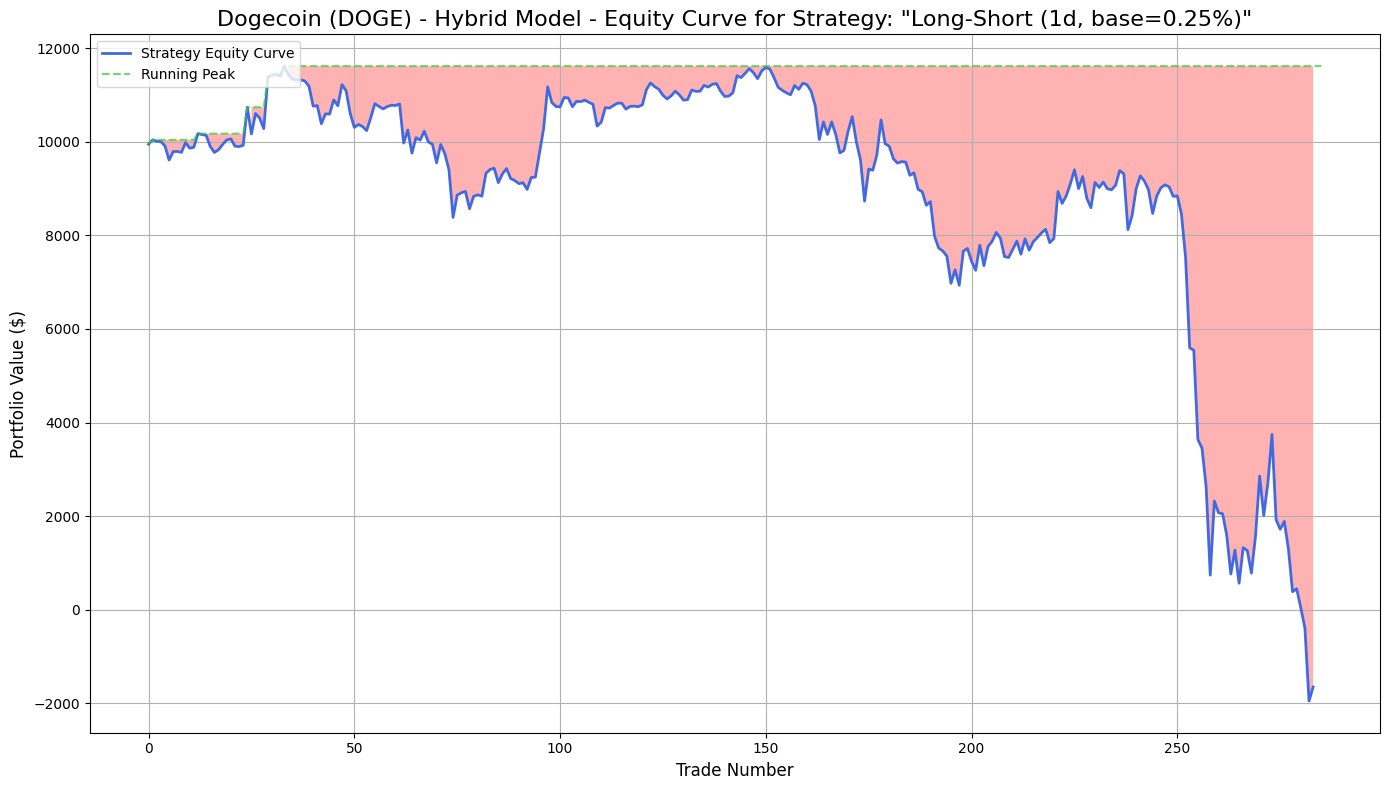


--- Running Backtest for Strategy: Long-Only (1d, base=0.5%) ---
Parameters: {'name': 'Long-Only (1d, base=0.5%)', 'type': 'long_only', 'trade_threshold': 0.016666666666666666, 'holding_period': 1, 'prediction_target': 'Target_1_Day_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Short (1d, base=0.5%) ---
Parameters: {'name': 'Long-Short (1d, base=0.5%)', 'type': 'long_short', 'trade_threshold': 0.016666666666666666, 'holding_period': 1, 'prediction_target': 'Target_1_Day_Pct_Change'}
Simulating trades with fixed holding period...


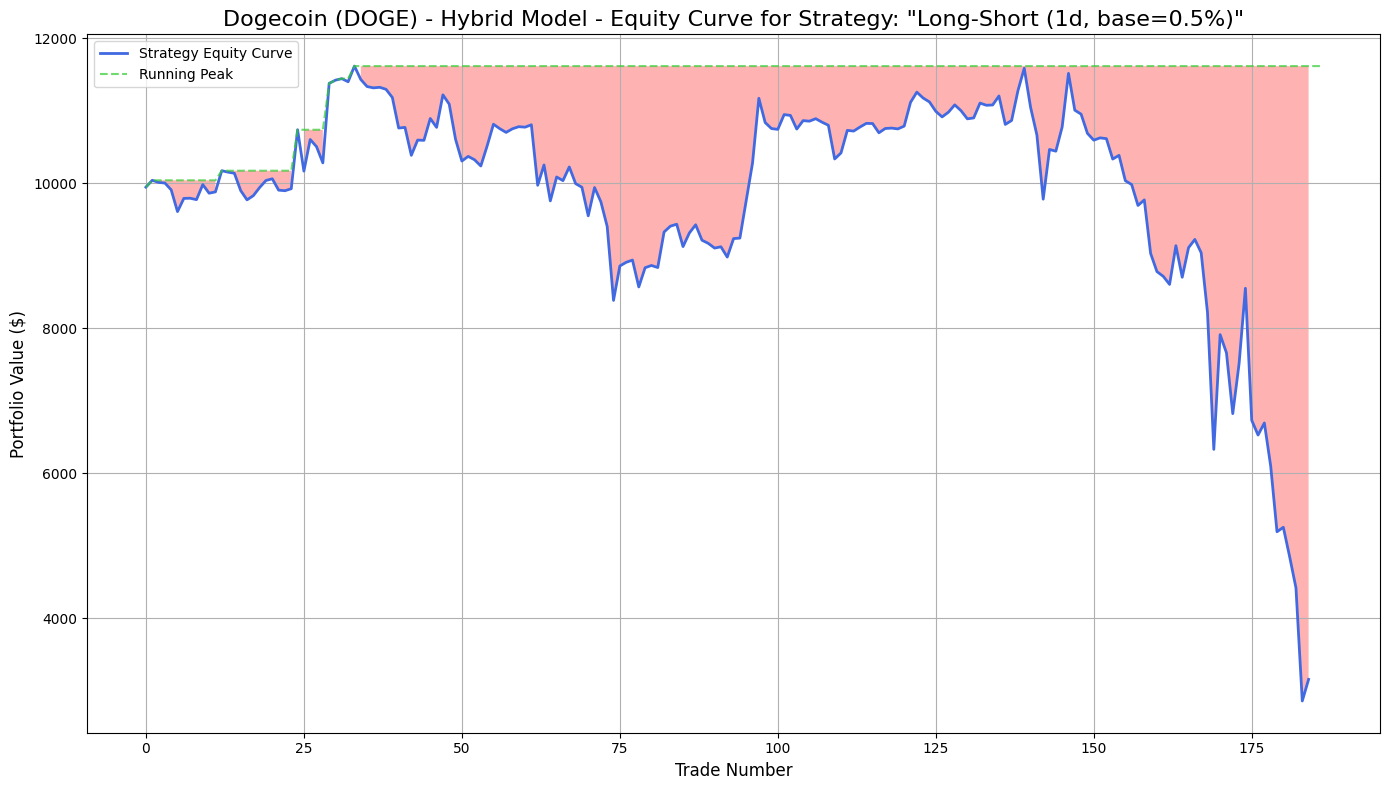


--- Running Backtest for Strategy: Long-Only (1d, base=1.0%) ---
Parameters: {'name': 'Long-Only (1d, base=1.0%)', 'type': 'long_only', 'trade_threshold': 0.03333333333333333, 'holding_period': 1, 'prediction_target': 'Target_1_Day_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Short (1d, base=1.0%) ---
Parameters: {'name': 'Long-Short (1d, base=1.0%)', 'type': 'long_short', 'trade_threshold': 0.03333333333333333, 'holding_period': 1, 'prediction_target': 'Target_1_Day_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Only (7d, base=0.25%) ---
Parameters: {'name': 'Long-Only (7d, base=0.25%)', 'type': 'long_only', 'trade_threshold': 0.058333333333333334, 'holding_period': 7, 'prediction_target': 'Target_7_Day_Pct_Change'}
Simulating trades with fixed holding period...

--- No t

C:\Users\Parthiva\AppData\Local\Temp\ipykernel_26932\1571922725.py:103: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


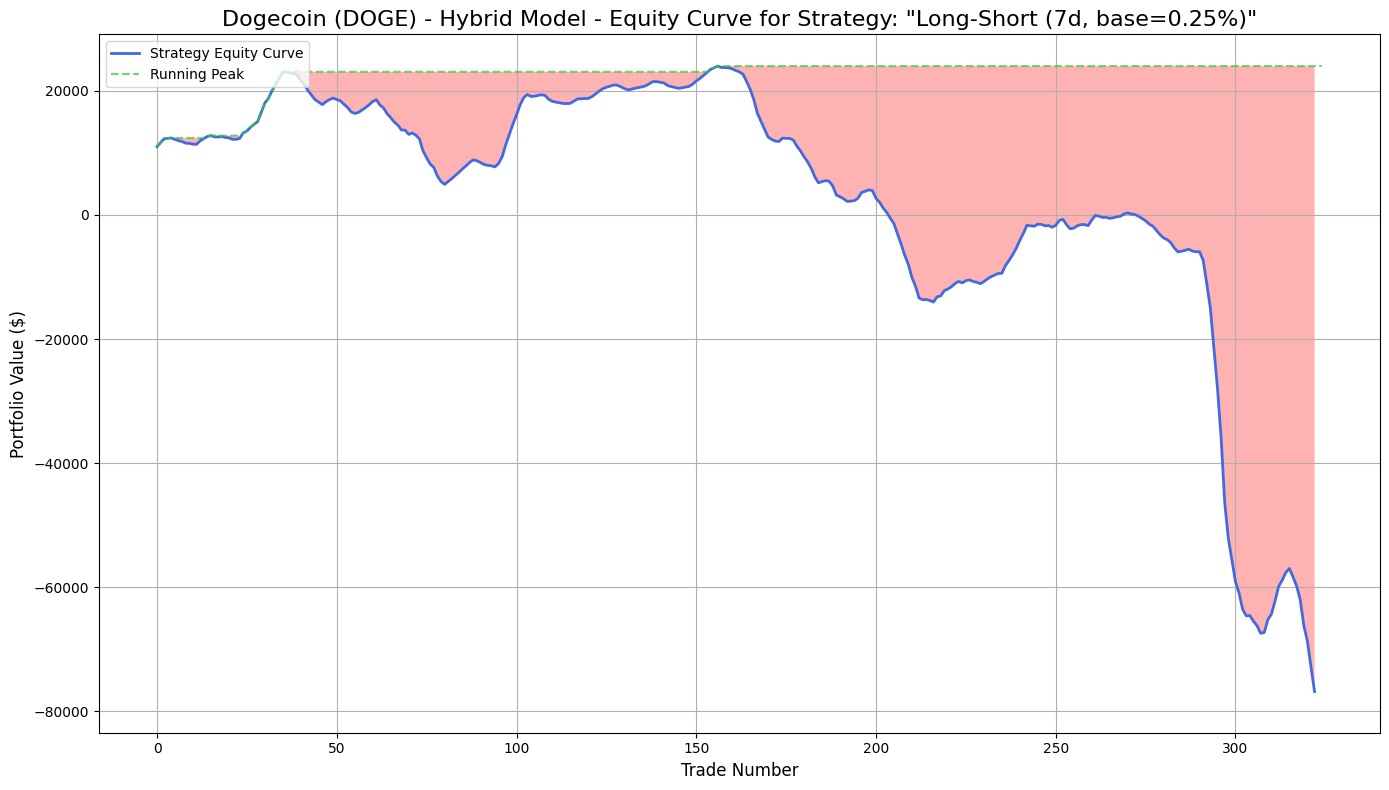


--- Running Backtest for Strategy: Long-Only (7d, base=0.5%) ---
Parameters: {'name': 'Long-Only (7d, base=0.5%)', 'type': 'long_only', 'trade_threshold': 0.11666666666666667, 'holding_period': 7, 'prediction_target': 'Target_7_Day_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Short (7d, base=0.5%) ---
Parameters: {'name': 'Long-Short (7d, base=0.5%)', 'type': 'long_short', 'trade_threshold': 0.11666666666666667, 'holding_period': 7, 'prediction_target': 'Target_7_Day_Pct_Change'}
Simulating trades with fixed holding period...


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_26932\1571922725.py:103: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return


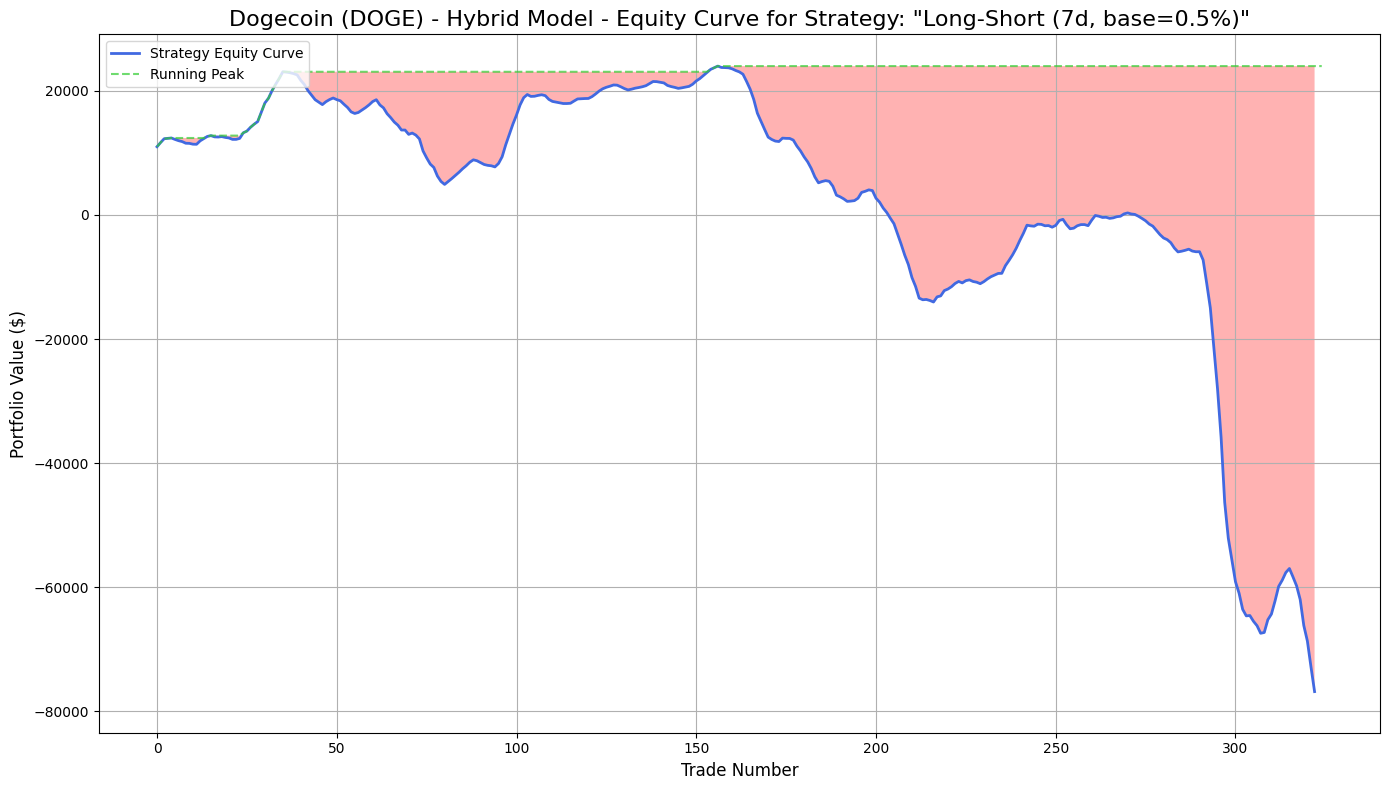


--- Running Backtest for Strategy: Long-Only (7d, base=1.0%) ---
Parameters: {'name': 'Long-Only (7d, base=1.0%)', 'type': 'long_only', 'trade_threshold': 0.23333333333333334, 'holding_period': 7, 'prediction_target': 'Target_7_Day_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Short (7d, base=1.0%) ---
Parameters: {'name': 'Long-Short (7d, base=1.0%)', 'type': 'long_short', 'trade_threshold': 0.23333333333333334, 'holding_period': 7, 'prediction_target': 'Target_7_Day_Pct_Change'}
Simulating trades with fixed holding period...


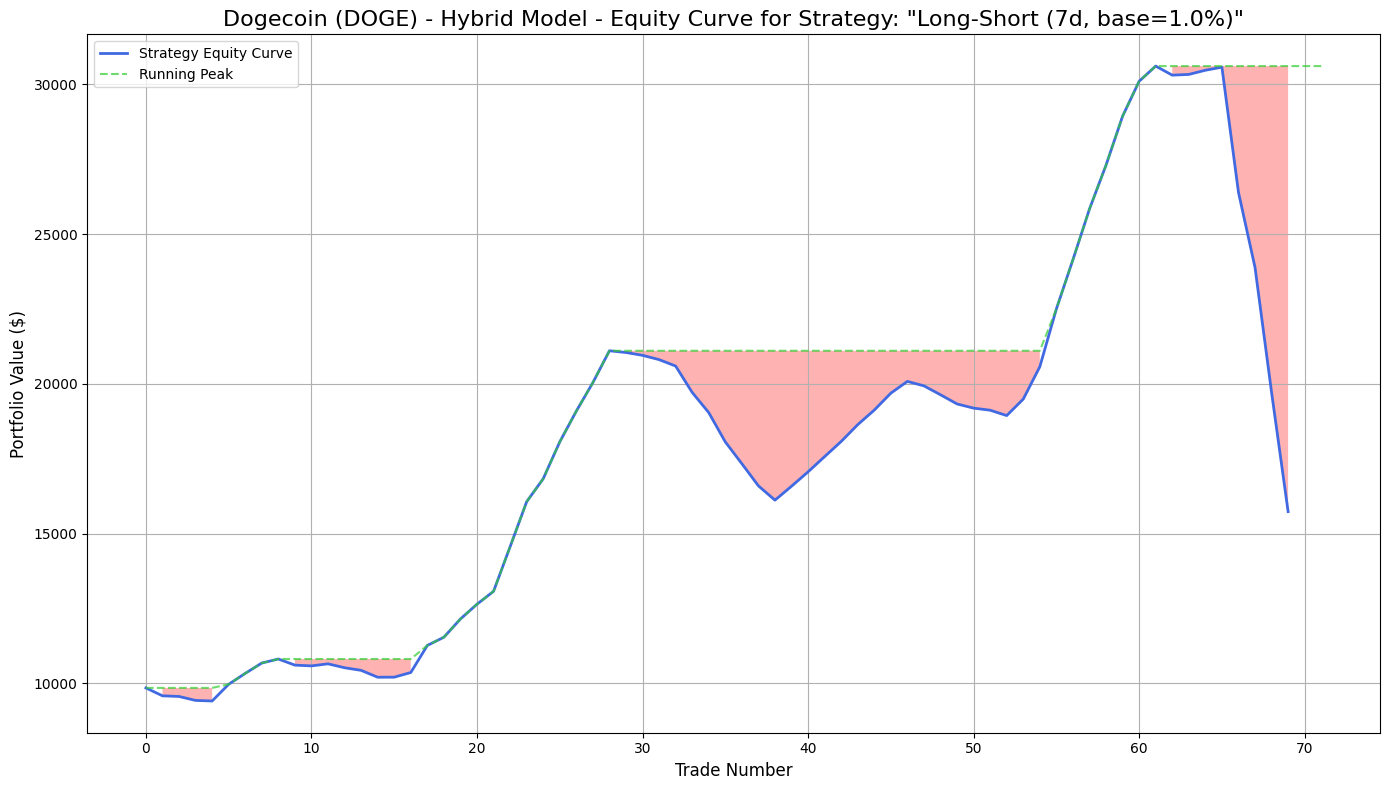


--- Running Backtest for Strategy: Long-Only (30d, base=0.25%) ---
Parameters: {'name': 'Long-Only (30d, base=0.25%)', 'type': 'long_only', 'trade_threshold': 0.25, 'holding_period': 30, 'prediction_target': 'Target_30_Day_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Short (30d, base=0.25%) ---
Parameters: {'name': 'Long-Short (30d, base=0.25%)', 'type': 'long_short', 'trade_threshold': 0.25, 'holding_period': 30, 'prediction_target': 'Target_30_Day_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Only (30d, base=0.5%) ---
Parameters: {'name': 'Long-Only (30d, base=0.5%)', 'type': 'long_only', 'trade_threshold': 0.5, 'holding_period': 30, 'prediction_target': 'Target_30_Day_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this str

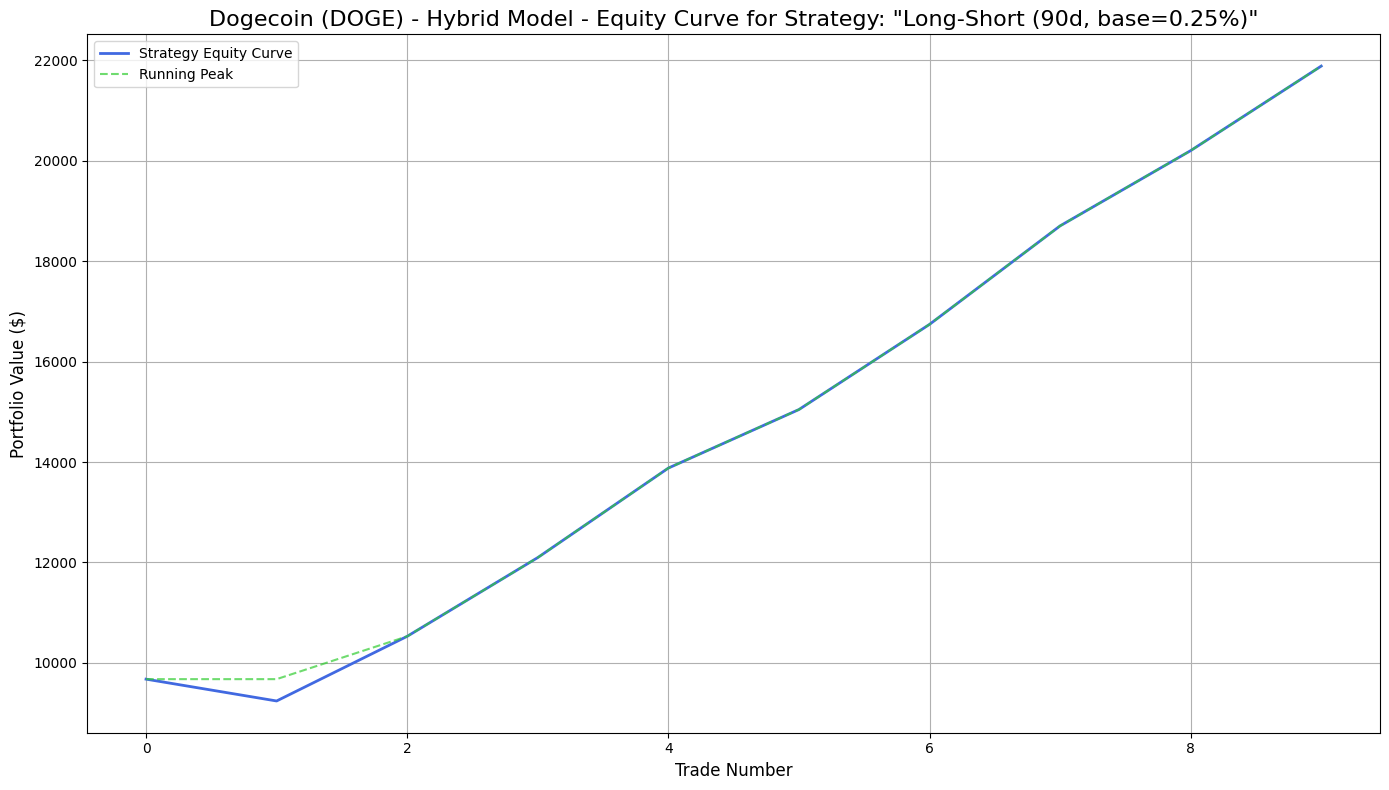


--- Running Backtest for Strategy: Long-Only (90d, base=0.5%) ---
Parameters: {'name': 'Long-Only (90d, base=0.5%)', 'type': 'long_only', 'trade_threshold': 1.5, 'holding_period': 90, 'prediction_target': 'Target_90_Day_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Short (90d, base=0.5%) ---
Parameters: {'name': 'Long-Short (90d, base=0.5%)', 'type': 'long_short', 'trade_threshold': 1.5, 'holding_period': 90, 'prediction_target': 'Target_90_Day_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Only (90d, base=1.0%) ---
Parameters: {'name': 'Long-Only (90d, base=1.0%)', 'type': 'long_only', 'trade_threshold': 3.0, 'holding_period': 90, 'prediction_target': 'Target_90_Day_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy.

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# --- 1. Model Definition (Must match the trained model) ---
class HybridLSTM(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(HybridLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=hidden_units, out_features=25)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)

    def forward(self, x):
        out, _ = self.lstm1(x); out = self.dropout1(out)
        out, _ = self.lstm2(out); out = self.dropout2(out)
        out = out[:, -1, :]; out = self.fc1(out)
        out = self.relu(out); out = self.fc2(out)
        return out

def run_backtest(asset_name, model_path, npz_path, raw_data_path, strategy_config):
    """
    A comprehensive backtesting function that simulates a given strategy and calculates advanced metrics.
    """
    strategy_name = strategy_config['name']
    print(f"\n{'='*30}\n--- Running Backtest for Strategy: {strategy_name} ---\n{'='*30}")
    print(f"Parameters: {strategy_config}")

    try:
        # --- Load Data & Model ---
        with np.load(npz_path, allow_pickle=True) as data:
            X_test, target_cols = data['X_test'], data['target_cols']
            X_test = X_test.astype(np.float32)

        raw_df = pd.read_csv(raw_data_path)
        # Handle Dogecoin's specific format ('Date' string)
        raw_df['Date'] = pd.to_datetime(raw_df['Date'])
        raw_df.sort_values('Date', inplace=True)
        raw_df.reset_index(drop=True, inplace=True)
        
        required_len = len(X_test) + strategy_config['holding_period']
        test_prices_df = raw_df.tail(required_len).copy().reset_index(drop=True)
        
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = HybridLSTM(X_test.shape[2], 40, len(target_cols)).to(device)
        model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
        model.eval()

        # --- Make Predictions ---
        test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test)), batch_size=256)
        all_preds = [];
        with torch.no_grad():
            for batch_X_tuple in test_loader:
                preds = model(batch_X_tuple[0].to(device))
                all_preds.append(preds.cpu().numpy())
        predictions = np.concatenate(all_preds, axis=0)
            
        target_col_index = np.where(target_cols == strategy_config['prediction_target'])[0][0]
        final_predictions = predictions[:, target_col_index]

        # --- Simulate Trades (Unified Logic) ---
        print("Simulating trades with fixed holding period...")
        trades = []
        holding_period = strategy_config['holding_period']
        threshold = strategy_config['trade_threshold']
        
        for i in range(len(final_predictions)):
            if i + holding_period >= len(test_prices_df): break
            prediction = final_predictions[i]
            entry_price = test_prices_df['Close'].iloc[i]
            exit_price = test_prices_df['Close'].iloc[i + holding_period]

            if prediction > threshold:
                trades.append({"return_pct": ((exit_price - entry_price) / entry_price) * 100})
            elif strategy_config['type'] == 'long_short' and prediction < -threshold:
                trades.append({"return_pct": ((entry_price - exit_price) / entry_price) * 100})

        if not trades: print("\n--- No trades were triggered for this strategy. ---"); return None

        # --- Calculate Metrics ---
        trades_df = pd.DataFrame(trades)
        total_trades = len(trades_df); winning_trades_df = trades_df[trades_df['return_pct'] > 0]; win_rate = len(winning_trades_df) / total_trades * 100
        avg_return_per_trade = trades_df['return_pct'].mean(); avg_profit_on_winners = winning_trades_df['return_pct'].mean()
        initial_capital = 10000; returns_series = trades_df['return_pct'] / 100; pnl_series = returns_series * initial_capital
        equity_curve = pnl_series.cumsum() + initial_capital; final_capital = equity_curve.iloc[-1]
        strategy_total_return = (final_capital - initial_capital) / initial_capital * 100
        days_in_test_period = (test_prices_df['Date'].iloc[-1] - test_prices_df['Date'].iloc[0]).days
        if returns_series.std() != 0 and days_in_test_period > 0 and total_trades > 0:
            sharpe_ratio = returns_series.mean() / returns_series.std()
            # Annualize based on daily data frequency
            annualization_factor = np.sqrt(365 / (days_in_test_period / total_trades))
            annualized_sharpe = sharpe_ratio * annualization_factor
        else: annualized_sharpe = 0
        peak = equity_curve.expanding(min_periods=1).max(); drawdown = (equity_curve - peak) / peak
        max_drawdown_pct = drawdown.min() * -100 if not drawdown.empty else 0
        years_in_test = days_in_test_period / 365.25 if days_in_test_period > 0 else 1
        annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return
        calmar_ratio = annualized_return / max_drawdown_pct if max_drawdown_pct > 0 else 0
        buy_hold_return = (test_prices_df['Close'].iloc[-1] - test_prices_df['Close'].iloc[0]) / test_prices_df['Close'].iloc[0] * 100
        
        # --- Plotting ---
        fig, ax = plt.subplots(figsize=(14, 8)); ax.plot(equity_curve.index, equity_curve, label='Strategy Equity Curve', color='royalblue', linewidth=2)
        ax.plot(peak.index, peak, label='Running Peak', color='limegreen', linestyle='--', alpha=0.7); ax.fill_between(drawdown.index, equity_curve, peak, where=equity_curve < peak, facecolor='red', alpha=0.3)
        ax.set_title(f'{asset_name} - Equity Curve for Strategy: "{strategy_name}"', fontsize=16); ax.set_xlabel('Trade Number', fontsize=12); ax.set_ylabel('Portfolio Value ($)', fontsize=12)
        ax.legend(loc='upper left'); ax.grid(True); plt.tight_layout(); plt.show()
        
        return {"Strategy": strategy_name, "Total Return (%)": strategy_total_return, "Buy & Hold (%)": buy_hold_return, "Sharpe Ratio": annualized_sharpe, "Calmar Ratio": calmar_ratio, "Max Drawdown (%)": max_drawdown_pct, "Win Rate (%)": win_rate, "Total Trades": total_trades}

    except Exception as e:
        print(f"An error occurred during backtest for '{strategy_name}': {e}")
        return None

def main():
    # --- Master Configuration for Dogecoin ---
    master_config = {
        "asset_name": "Dogecoin (DOGE) - Hybrid Model",
        "model_path": "doge_hybrid_pytorch_model.pth",
        "npz_path": "doge_hybrid_pytorch_data.npz",
        "raw_data_path": "E:\\DOGE-USD.csv",
    }

    horizons = {
        "1d": {"holding_period": 1, "target_col": "Target_1_Day_Pct_Change"},
        "7d": {"holding_period": 7, "target_col": "Target_7_Day_Pct_Change"},
        "30d": {"holding_period": 30, "target_col": "Target_30_Day_Pct_Change"},
        "90d": {"holding_period": 90, "target_col": "Target_90_Day_Pct_Change"},
    }
    base_thresholds = [0.25, 0.5, 1.0]
    strategy_types = ["long_only", "long_short"]

    all_strategies = []
    # --- Programmatically Generate All 24 Strategies ---
    for horizon_name, horizon_props in horizons.items():
        for base_thresh in base_thresholds:
            days_in_horizon = horizon_props["holding_period"]
            scaled_threshold = base_thresh * (days_in_horizon / 30.0)

            for strat_type in strategy_types:
                strategy_name_human = f"{strat_type.replace('_','-').title()} ({horizon_name}, base={base_thresh}%)"
                all_strategies.append({
                    "name": strategy_name_human,
                    "type": strat_type,
                    "trade_threshold": scaled_threshold,
                    "holding_period": horizon_props["holding_period"],
                    "prediction_target": horizon_props["target_col"],
                })

    summary_results = []
    for strategy_config in all_strategies:
        result = run_backtest(**master_config, strategy_config=strategy_config)
        if result:
            summary_results.append(result)
    
    if summary_results:
        print("\n\n" + "="*40); print("--- MASTER STRATEGY COMPARISON (DOGECOIN) ---"); print("="*40)
        summary_df = pd.DataFrame(summary_results).set_index("Strategy")
        pd.options.display.float_format = '{:,.2f}'.format
        print(summary_df)

if __name__ == "__main__":
    main()


--- Running Backtest for Strategy: Long-Only (1d, base=0.25%) ---

--- No trades triggered. ---

--- Running Backtest for Strategy: Long-Short (1d, base=0.25%) ---


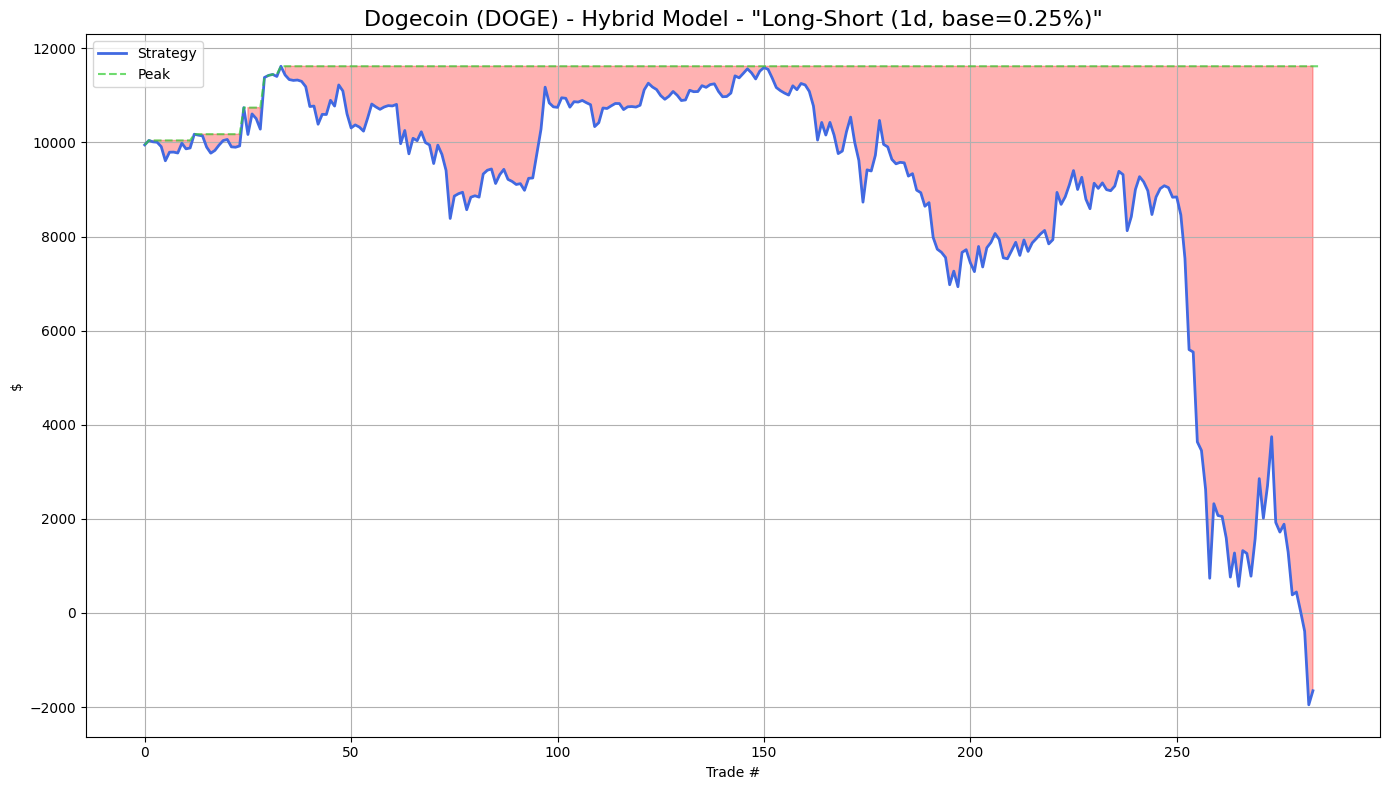


--- Running Backtest for Strategy: Long-Only (1d, base=0.5%) ---

--- No trades triggered. ---

--- Running Backtest for Strategy: Long-Short (1d, base=0.5%) ---


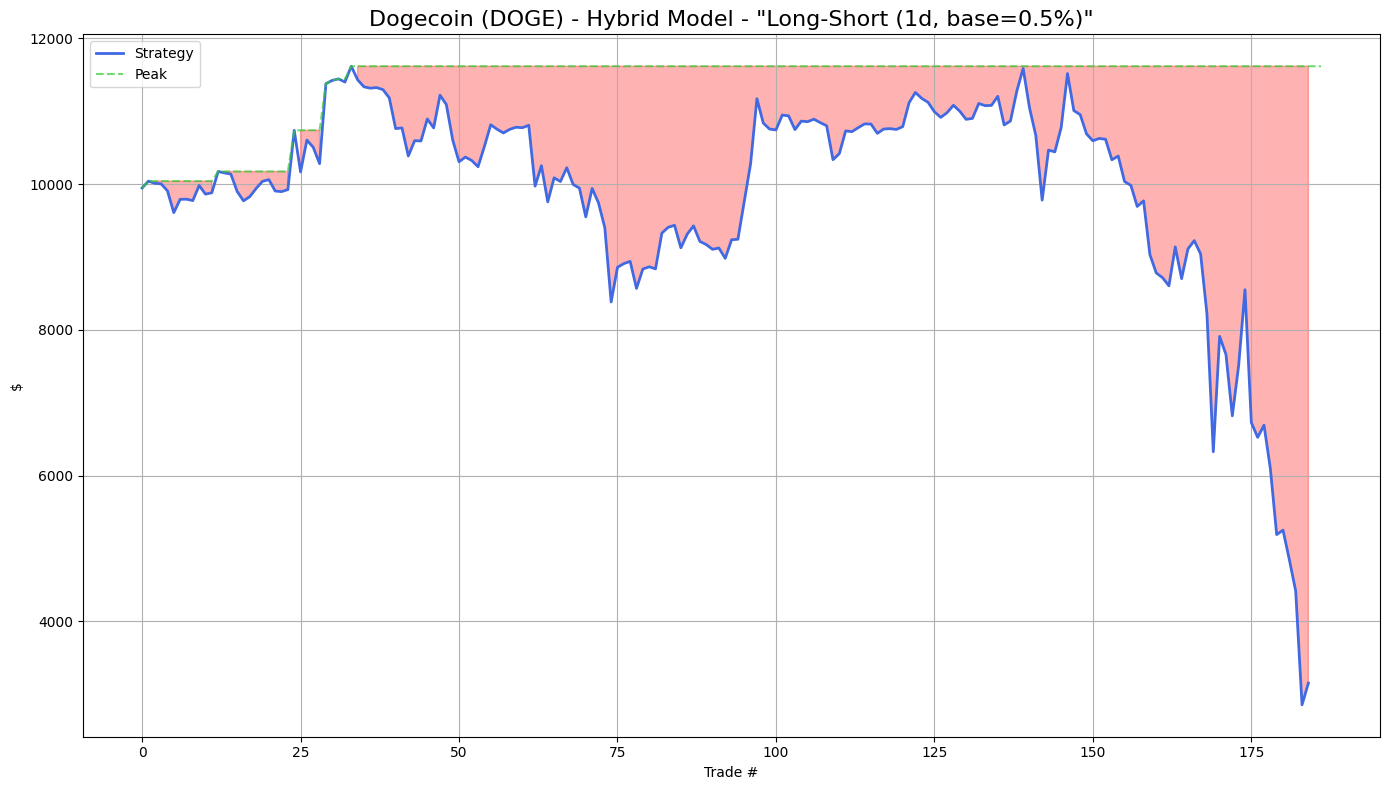


--- Running Backtest for Strategy: Long-Only (1d, base=1.0%) ---

--- No trades triggered. ---

--- Running Backtest for Strategy: Long-Short (1d, base=1.0%) ---

--- No trades triggered. ---

--- Running Backtest for Strategy: Long-Only (7d, base=0.25%) ---

--- No trades triggered. ---

--- Running Backtest for Strategy: Long-Short (7d, base=0.25%) ---


C:\Users\Parthiva\AppData\Local\Temp\ipykernel_24580\2031453130.py:37: RuntimeWarning: invalid value encountered in scalar power
  years_in_test=days_in_test/365.25 if days_in_test>0 else 1; ann_return=((final_capital/initial_capital)**(1/years_in_test)-1)*100 if years_in_test>0 else strategy_total_return


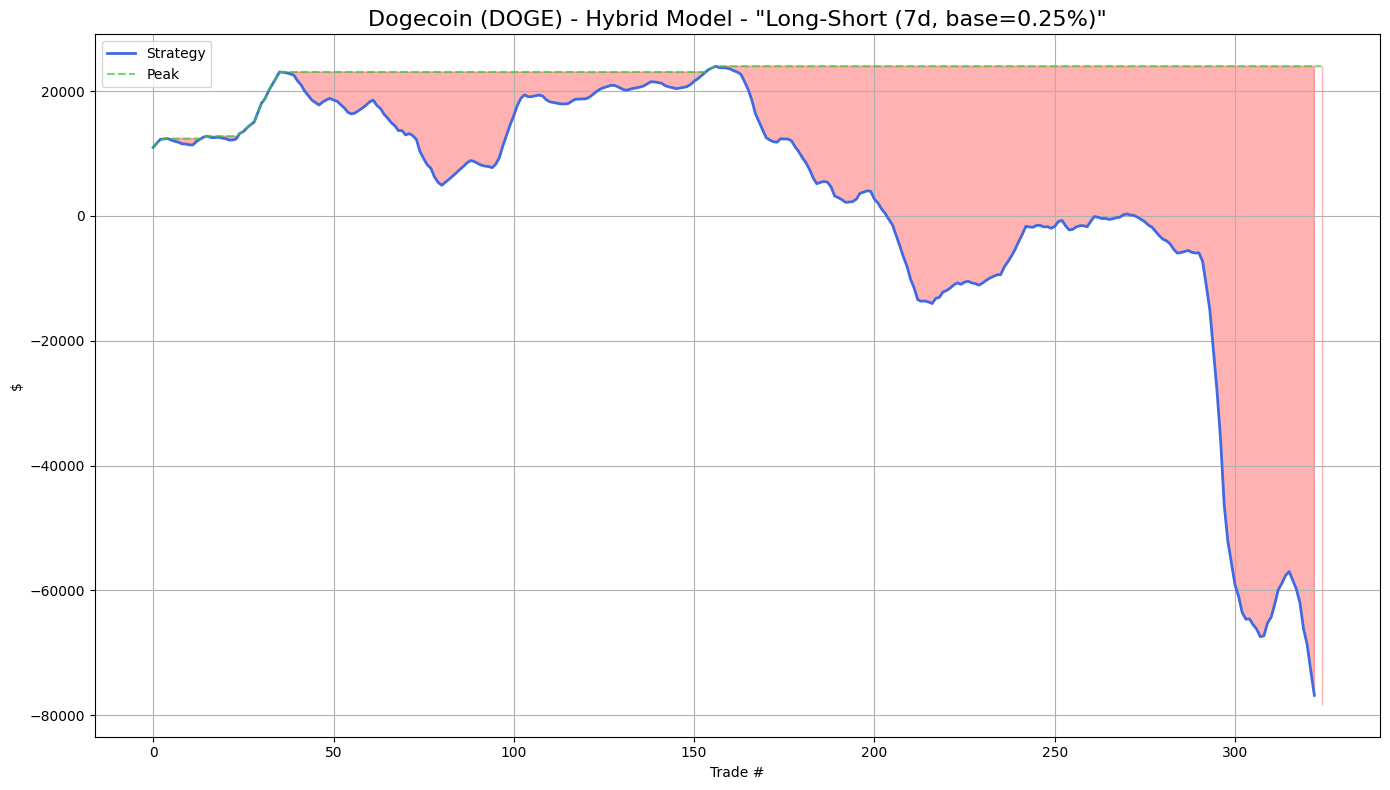

C:\Users\Parthiva\AppData\Local\Temp\ipykernel_24580\2031453130.py:37: RuntimeWarning: invalid value encountered in scalar power
  years_in_test=days_in_test/365.25 if days_in_test>0 else 1; ann_return=((final_capital/initial_capital)**(1/years_in_test)-1)*100 if years_in_test>0 else strategy_total_return



--- Running Backtest for Strategy: Long-Only (7d, base=0.5%) ---

--- No trades triggered. ---

--- Running Backtest for Strategy: Long-Short (7d, base=0.5%) ---


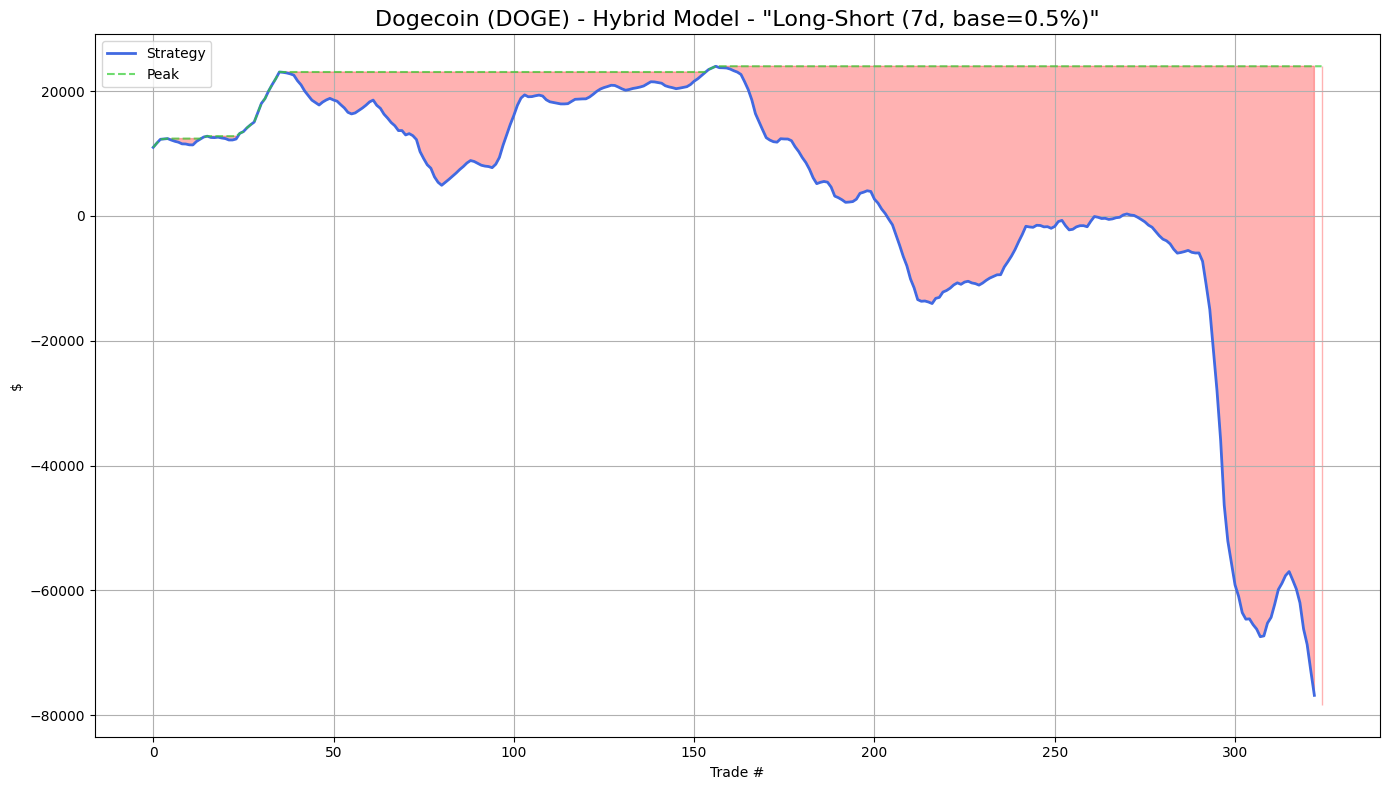


--- Running Backtest for Strategy: Long-Only (7d, base=1.0%) ---

--- No trades triggered. ---

--- Running Backtest for Strategy: Long-Short (7d, base=1.0%) ---


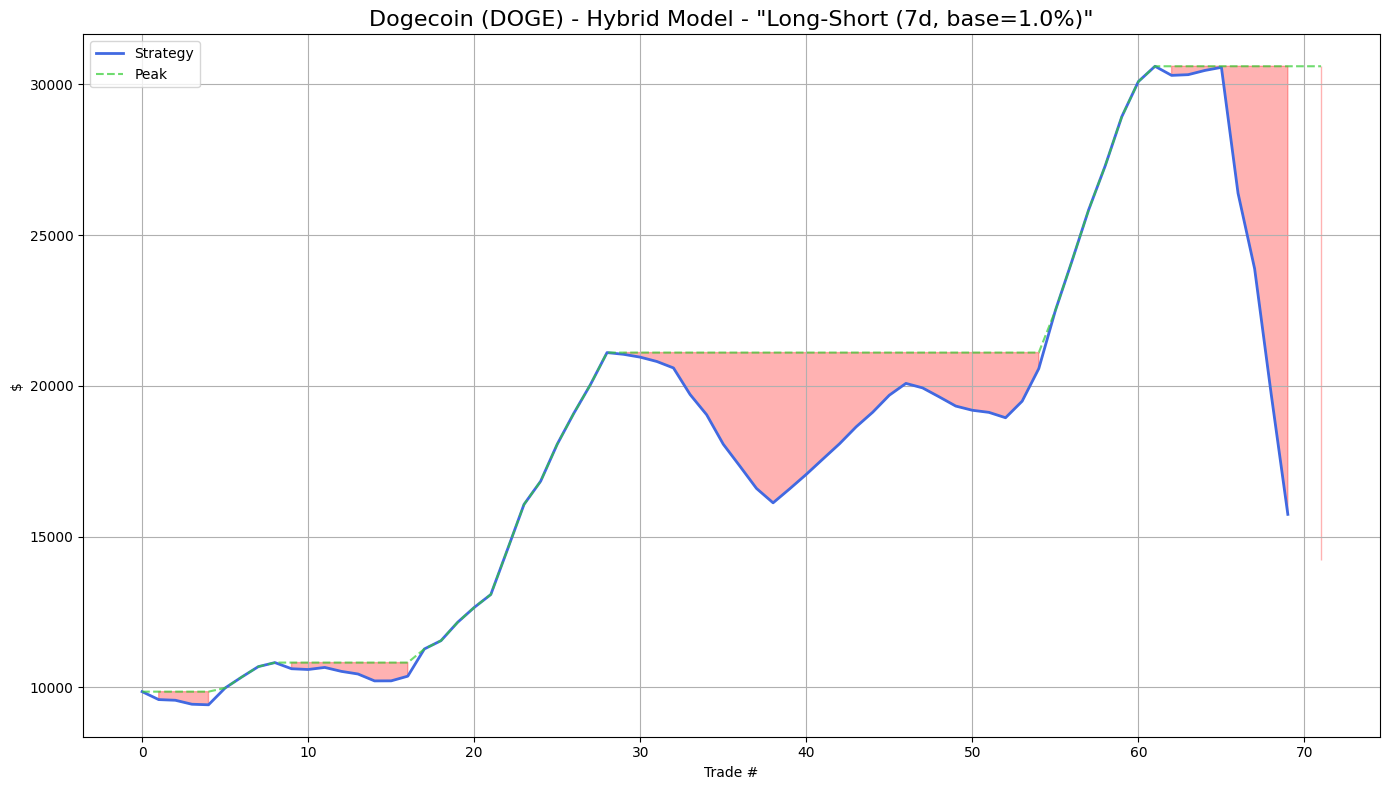


--- Running Backtest for Strategy: Long-Only (30d, base=0.25%) ---

--- No trades triggered. ---

--- Running Backtest for Strategy: Long-Short (30d, base=0.25%) ---

--- No trades triggered. ---

--- Running Backtest for Strategy: Long-Only (30d, base=0.5%) ---

--- No trades triggered. ---

--- Running Backtest for Strategy: Long-Short (30d, base=0.5%) ---

--- No trades triggered. ---

--- Running Backtest for Strategy: Long-Only (30d, base=1.0%) ---

--- No trades triggered. ---

--- Running Backtest for Strategy: Long-Short (30d, base=1.0%) ---

--- No trades triggered. ---

--- Running Backtest for Strategy: Long-Only (90d, base=0.25%) ---

--- No trades triggered. ---

--- Running Backtest for Strategy: Long-Short (90d, base=0.25%) ---


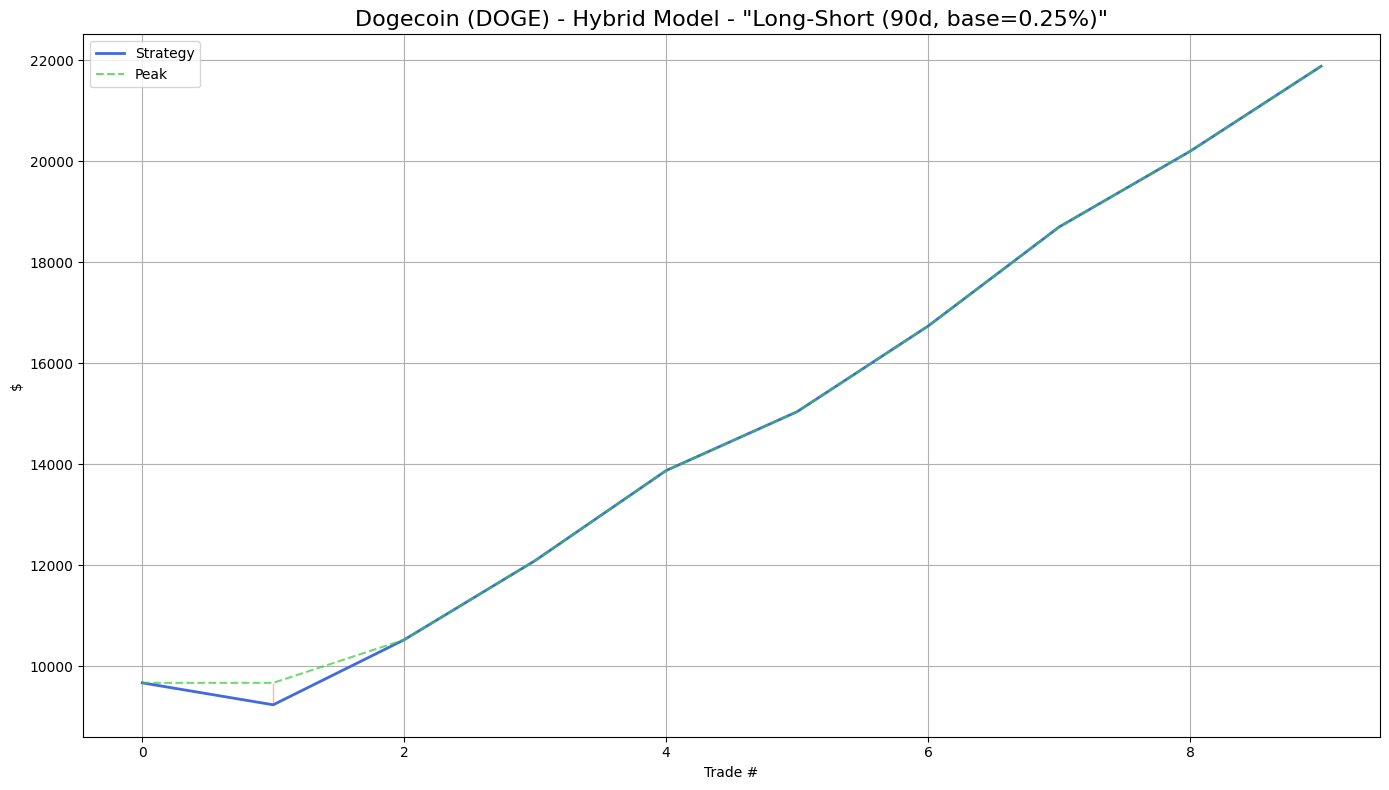


--- Running Backtest for Strategy: Long-Only (90d, base=0.5%) ---

--- No trades triggered. ---

--- Running Backtest for Strategy: Long-Short (90d, base=0.5%) ---

--- No trades triggered. ---

--- Running Backtest for Strategy: Long-Only (90d, base=1.0%) ---

--- No trades triggered. ---

--- Running Backtest for Strategy: Long-Short (90d, base=1.0%) ---

--- No trades triggered. ---


--- MASTER STRATEGY COMPARISON (DOGECOIN) ---
                              Total Return (%)  Buy & Hold (%)  Sharpe Ratio  \
Strategy                                                                       
Long-Short (1d, base=0.25%)                NaN          181.77         -1.72   
Long-Short (1d, base=0.5%)                 NaN          181.77         -1.31   
Long-Short (7d, base=0.25%)            -883.35          152.66         -3.95   
Long-Short (7d, base=0.5%)             -883.35          152.66         -3.95   
Long-Short (7d, base=1.0%)               42.24          152.66          0.46   
Lo

In [6]:
import pandas as pd; import numpy as np; import torch; import torch.nn as nn; from torch.utils.data import DataLoader, TensorDataset; import matplotlib.pyplot as plt
# --- The CORRECT Model Definition ---
class HybridLSTM(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(HybridLSTM, self).__init__(); self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True); self.dropout1 = nn.Dropout(0.2); self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True); self.dropout2 = nn.Dropout(0.2); self.fc1 = nn.Linear(in_features=hidden_units, out_features=25); self.relu = nn.ReLU(); self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)
    def forward(self, x):
        out, _ = self.lstm1(x); out = self.dropout1(out); out, _ = self.lstm2(out); out = self.dropout2(out); out = out[:, -1, :]; out = self.fc1(out); out = self.relu(out); out = self.fc2(out); return out
def run_backtest(asset_name, model_path, npz_path, raw_data_path, strategy_config):
    strategy_name = strategy_config['name']; print(f"\n{'='*30}\n--- Running Backtest for Strategy: {strategy_name} ---\n{'='*30}")
    try:
        with np.load(npz_path, allow_pickle=True) as data: X_test, target_cols = data['X_test'], data['target_cols']
        raw_df = pd.read_csv(raw_data_path); raw_df['Date']=pd.to_datetime(raw_df['Date']); raw_df.sort_values('Date',inplace=True); raw_df.reset_index(drop=True,inplace=True)
        required_len=len(X_test)+strategy_config['holding_period']; test_prices_df=raw_df.tail(required_len).copy().reset_index(drop=True)
        device="cuda" if torch.cuda.is_available() else "cpu"; model=HybridLSTM(X_test.shape[2],40,len(target_cols)).to(device); model.load_state_dict(torch.load(model_path,map_location=torch.device(device))); model.eval()
        test_loader=DataLoader(TensorDataset(torch.from_numpy(X_test.astype(np.float32))),batch_size=256); all_preds=[]
        with torch.no_grad():
            for b in test_loader: p=model(b[0].to(device)); all_preds.append(p.cpu().numpy())
        predictions=np.concatenate(all_preds,axis=0); target_col_index=np.where(target_cols==strategy_config['prediction_target'])[0][0]; final_predictions=predictions[:,target_col_index]
        trades=[]
        if strategy_config['type']=='long_only':
            for i in range(len(final_predictions)):
                if i+strategy_config['holding_period']>=len(test_prices_df): break
                if final_predictions[i]>strategy_config['trade_threshold']: entry=test_prices_df['Close'].iloc[i]; exit_price=test_prices_df['Close'].iloc[i+strategy_config['holding_period']]; trades.append({"return_pct":((exit_price-entry)/entry)*100})
        elif strategy_config['type']=='long_short':
            for i in range(len(final_predictions)):
                if i+strategy_config['holding_period']>=len(test_prices_df): break
                prediction=final_predictions[i]; entry_price=test_prices_df['Close'].iloc[i]; exit_price=test_prices_df['Close'].iloc[i+strategy_config['holding_period']]
                if prediction>strategy_config['trade_threshold']: trades.append({"return_pct":((exit_price-entry_price)/entry_price)*100})
                elif prediction<-strategy_config['trade_threshold']: trades.append({"return_pct":((entry_price-exit_price)/entry_price)*100})
        if not trades: print("\n--- No trades triggered. ---"); return None
        trades_df=pd.DataFrame(trades); total_trades=len(trades_df); win_df=trades_df[trades_df['return_pct']>0]; win_rate=len(win_df)/total_trades*100
        initial_capital=10000; returns_series=trades_df['return_pct']/100; pnl_series=returns_series*initial_capital; equity_curve=pnl_series.cumsum()+initial_capital
        final_capital=equity_curve.iloc[-1]; strategy_total_return=(final_capital-initial_capital)/initial_capital*100; days_in_test=(test_prices_df['Date'].iloc[-1]-test_prices_df['Date'].iloc[0]).days
        if returns_series.std()!=0 and days_in_test>0 and total_trades>0: sharp=returns_series.mean()/returns_series.std(); ann_factor=np.sqrt(365/(days_in_test/total_trades)); ann_sharp=sharp*ann_factor
        else: ann_sharp=0
        peak=equity_curve.expanding(min_periods=1).max(); drawdown=(equity_curve-peak)/peak; max_dd=drawdown.min()*-100 if not drawdown.empty else 0
        years_in_test=days_in_test/365.25 if days_in_test>0 else 1; ann_return=((final_capital/initial_capital)**(1/years_in_test)-1)*100 if years_in_test>0 else strategy_total_return
        calmar=ann_return/max_dd if max_dd>0 else 0; buy_hold=(test_prices_df['Close'].iloc[-1]-test_prices_df['Close'].iloc[0])/test_prices_df['Close'].iloc[0]*100
        fig,ax=plt.subplots(figsize=(14,8)); ax.plot(equity_curve.index,equity_curve,label='Strategy',color='royalblue',lw=2); ax.plot(peak.index,peak,label='Peak',color='limegreen',ls='--',alpha=0.7); ax.fill_between(drawdown.index,equity_curve,peak,where=equity_curve<peak,color='red',alpha=0.3)
        ax.set_title(f'{asset_name} - "{strategy_name}"',fontsize=16); ax.set_xlabel('Trade #'); ax.set_ylabel('$'); ax.legend(loc='upper left'); ax.grid(True); plt.tight_layout(); plt.show()
        return {"Strategy":strategy_name, "Total Return (%)":strategy_total_return, "Buy & Hold (%)":buy_hold, "Sharpe Ratio":ann_sharp, "Calmar Ratio":calmar, "Max Drawdown (%)":max_dd, "Win Rate (%)":win_rate, "Total Trades":total_trades}
    except Exception as e: print(f"Error for '{strategy_name}': {e}"); return None
def main():
    master_config = {"asset_name": "Dogecoin (DOGE) - Hybrid Model", "model_path": "doge_hybrid_pytorch_model.pth", "npz_path": "doge_hybrid_pytorch_data.npz", "raw_data_path": "E:\\DOGE-USD.csv"}
    horizons = {"1d": {"holding_period": 1, "target_col": "Target_1_Day_Pct_Change"}, "7d": {"holding_period": 7, "target_col": "Target_7_Day_Pct_Change"}, "30d": {"holding_period": 30, "target_col": "Target_30_Day_Pct_Change"}, "90d": {"holding_period": 90, "target_col": "Target_90_Day_Pct_Change"}}
    base_thresholds = [0.25, 0.5, 1.0]; strategy_types = ["long_only", "long_short"]
    all_strategies = []
    for h_name, h_props in horizons.items():
        for b_thresh in base_thresholds:
            s_thresh = b_thresh * (h_props["holding_period"] / 30.0)
            for s_type in strategy_types:
                name = f"{s_type.replace('_','-').title()} ({h_name}, base={b_thresh}%)"; all_strategies.append({"name":name, "type":s_type, "trade_threshold":s_thresh, "holding_period":h_props["holding_period"], "prediction_target":h_props["target_col"]})
    summary_results = [r for s_config in all_strategies if (r := run_backtest(**master_config, strategy_config=s_config)) is not None]
    if summary_results:
        print("\n\n" + "="*40); print("--- MASTER STRATEGY COMPARISON (DOGECOIN) ---"); print("="*40)
        summary_df = pd.DataFrame(summary_results).set_index("Strategy"); pd.options.display.float_format = '{:,.2f}'.format; print(summary_df)
        output_csv_filename = "dogecoin_backtest_summary.csv"; summary_df.to_csv(output_csv_filename, float_format='%.2f'); print(f"\nSummary also saved to: {output_csv_filename}")
if __name__ == "__main__": main()

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# --- 1. Model Definition (Must match the trained model) ---
class HybridLSTM(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(HybridLSTM, self).__init__(); self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True); self.dropout1 = nn.Dropout(0.2); self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True); self.dropout2 = nn.Dropout(0.2); self.fc1 = nn.Linear(in_features=hidden_units, out_features=25); self.relu = nn.ReLU(); self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)
    def forward(self, x):
        out, _ = self.lstm1(x); out = self.dropout1(out); out, _ = self.lstm2(out); out = self.dropout2(out); out = out[:, -1, :]; out = self.fc1(out); out = self.relu(out); out = self.fc2(out); return out

def run_backtest(asset_name, model_path, npz_path, raw_data_path, strategy_config):
    strategy_name = strategy_config['name']; print(f"\n{'='*30}\n--- Running Backtest for Strategy: {strategy_name} ---\n{'='*30}")
    try:
        with np.load(npz_path, allow_pickle=True) as data: X_test, target_cols = data['X_test'], data['target_cols']
        raw_df = pd.read_csv(raw_data_path); raw_df['Date']=pd.to_datetime(raw_df['Date']); raw_df.sort_values('Date',inplace=True); raw_df.reset_index(drop=True,inplace=True)
        required_len=len(X_test)+strategy_config['holding_period']; test_prices_df=raw_df.tail(required_len).copy().reset_index(drop=True)
        device="cuda" if torch.cuda.is_available() else "cpu"; model=HybridLSTM(X_test.shape[2],40,len(target_cols)).to(device); model.load_state_dict(torch.load(model_path,map_location=torch.device(device))); model.eval()
        test_loader=DataLoader(TensorDataset(torch.from_numpy(X_test.astype(np.float32))),batch_size=256); all_preds=[]
        with torch.no_grad():
            for b in test_loader: p=model(b[0].to(device)); all_preds.append(p.cpu().numpy())
        predictions=np.concatenate(all_preds,axis=0); target_col_index=np.where(target_cols==strategy_config['prediction_target'])[0][0]; final_predictions=predictions[:,target_col_index]
        trades=[]
        if strategy_config['type']=='long_only':
            for i in range(len(final_predictions)):
                if i+strategy_config['holding_period']>=len(test_prices_df): break
                if final_predictions[i]>strategy_config['trade_threshold']: entry=test_prices_df['Close'].iloc[i]; exit_price=test_prices_df['Close'].iloc[i+strategy_config['holding_period']]; trades.append({"return_pct":((exit_price-entry)/entry)*100})
        elif strategy_config['type']=='long_short':
            for i in range(len(final_predictions)):
                if i+strategy_config['holding_period']>=len(test_prices_df): break
                prediction=final_predictions[i]; entry_price=test_prices_df['Close'].iloc[i]; exit_price=test_prices_df['Close'].iloc[i+strategy_config['holding_period']]
                if prediction>strategy_config['trade_threshold']: trades.append({"return_pct":((exit_price-entry_price)/entry_price)*100})
                elif prediction<-strategy_config['trade_threshold']: trades.append({"return_pct":((entry_price-exit_price)/entry_price)*100})
        if not trades: print("\n--- No trades were triggered. ---"); return None
        trades_df=pd.DataFrame(trades); total_trades=len(trades_df); win_df=trades_df[trades_df['return_pct']>0]; win_rate=len(win_df)/total_trades*100
        initial_capital=10000; returns_series=trades_df['return_pct']/100; pnl_series=returns_series*initial_capital; equity_curve=pnl_series.cumsum()+initial_capital
        final_capital=equity_curve.iloc[-1]; strategy_total_return=(final_capital-initial_capital)/initial_capital*100; days_in_test=(test_prices_df['Date'].iloc[-1]-test_prices_df['Date'].iloc[0]).days
        if returns_series.std()!=0 and days_in_test>0 and total_trades>0: sharp=returns_series.mean()/returns_series.std(); ann_factor=np.sqrt(365/(days_in_test/total_trades)); ann_sharp=sharp*ann_factor
        else: ann_sharp=0
        peak=equity_curve.expanding(min_periods=1).max(); drawdown=(equity_curve-peak)/peak; max_dd=drawdown.min()*-100 if not drawdown.empty else 0
        years_in_test=days_in_test/365.25 if days_in_test>0 else 1; ann_return=((final_capital/initial_capital)**(1/years_in_test)-1)*100 if years_in_test>0 else strategy_total_return
        calmar=ann_return/max_dd if max_dd>0 else 0; buy_hold=(test_prices_df['Close'].iloc[-1]-test_prices_df['Close'].iloc[0])/test_prices_df['Close'].iloc[0]*100
        fig,ax=plt.subplots(figsize=(14,8)); ax.plot(equity_curve.index,equity_curve,label='Strategy',color='royalblue',lw=2); ax.plot(peak.index,peak,label='Peak',color='limegreen',ls='--',alpha=0.7); ax.fill_between(drawdown.index,equity_curve,peak,where=equity_curve<peak,color='red',alpha=0.3)
        ax.set_title(f'{asset_name} - "{strategy_name}"',fontsize=16); ax.set_xlabel('Trade #'); ax.set_ylabel('$'); ax.legend(loc='upper left'); ax.grid(True); plt.tight_layout(); plt.show()
        return {"Strategy":strategy_name, "Total Return (%)":strategy_total_return, "Buy & Hold (%)":buy_hold, "Sharpe Ratio":ann_sharp, "Calmar Ratio":calmar, "Max Drawdown (%)":max_dd, "Win Rate (%)":win_rate, "Total Trades":total_trades}
    except Exception as e: print(f"Error for '{strategy_name}': {e}"); return None

def main():
    master_config = {
        "asset_name": "Dogecoin (DOGE) - Hybrid Model",
        "model_path": "doge_hybrid_pytorch_model.pth",
        "npz_path": "doge_hybrid_pytorch_data.npz",
        "raw_data_path": "E:\\DOGE-USD.csv",
    }
    horizons = {
        "1d": {"holding_period": 1, "target_col": "Target_1_Day_Pct_Change"},
        "7d": {"holding_period": 7, "target_col": "Target_7_Day_Pct_Change"},
        "30d": {"holding_period": 30, "target_col": "Target_30_Day_Pct_Change"},
        "90d": {"holding_period": 90, "target_col": "Target_90_Day_Pct_Change"},
    }
    base_thresholds = [0.25, 0.5, 1.0]; strategy_types = ["long_only", "long_short"]
    all_strategies = []
    
    # --- NEW: MULTIPLICATIVE THRESHOLD LOGIC ---
    for horizon_name, horizon_props in horizons.items():
        for base_thresh in base_thresholds:
            days_in_horizon = horizon_props["holding_period"]
            # The threshold is now multiplied by the holding period in days
            scaled_threshold = base_thresh * days_in_horizon

            for strat_type in strategy_types:
                strategy_name_human = f"{strat_type.replace('_','-').title()} ({horizon_name}, base={base_thresh}%)"
                all_strategies.append({
                    "name": strategy_name_human,
                    "type": strat_type,
                    "trade_threshold": scaled_threshold,
                    "holding_period": horizon_props["holding_period"],
                    "prediction_target": horizon_props["target_col"],
                })

    summary_results = [r for s_config in all_strategies if (r := run_backtest(**master_config, strategy_config=s_config)) is not None]
    if summary_results:
        print("\n\n" + "="*40); print("--- MASTER STRATEGY COMPARISON (DOGECOIN) ---"); print("="*40)
        summary_df = pd.DataFrame(summary_results).set_index("Strategy"); pd.options.display.float_format = '{:,.2f}'.format; print(summary_df)
        output_csv_filename = "dogecoin_backtest_summary.csv"; summary_df.to_csv(output_csv_filename, float_format='%.2f'); print(f"\nSummary also saved to: {output_csv_filename}")

if __name__ == "__main__":
    main()


--- Running Backtest for Strategy: Long-Only (1d, base=0.25%) ---

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Short (1d, base=0.25%) ---

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Only (1d, base=0.5%) ---

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Short (1d, base=0.5%) ---

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Only (1d, base=1.0%) ---

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Short (1d, base=1.0%) ---

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Only (7d, base=0.25%) ---

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Short (7d, base=0.25%) ---

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Only (7d, base=0.5%) ---

--- No trades were triggered. ---

--- Running Backtest for Strategy: Long-Short (7d, base=0.5%) ---

--- No trades w

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# --- 1. Model Definition (Must match the trained model) ---
class HybridLSTM(nn.Module):
    def __init__(self, input_features, hidden_units, num_outputs):
        super(HybridLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_features, hidden_size=hidden_units, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=hidden_units, out_features=25)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=25, out_features=num_outputs)

    def forward(self, x):
        out, _ = self.lstm1(x); out = self.dropout1(out)
        out, _ = self.lstm2(out); out = self.dropout2(out)
        out = out[:, -1, :]; out = self.fc1(out)
        out = self.relu(out); out = self.fc2(out)
        return out

def run_backtest(asset_name, model_path, npz_path, raw_data_path, strategy_config):
    """
    A comprehensive backtesting function that simulates a given strategy and calculates advanced metrics.
    """
    strategy_name = strategy_config['name']
    print(f"\n{'='*30}\n--- Running Backtest for Strategy: {strategy_name} ---\n{'='*30}")
    print(f"Parameters: {strategy_config}")

    try:
        # --- Load Data & Model ---
        with np.load(npz_path, allow_pickle=True) as data:
            X_test, target_cols = data['X_test'], data['target_cols']
            X_test = X_test.astype(np.float32)

        raw_df = pd.read_csv(raw_data_path)
        # Handle Dogecoin's specific format ('Date' string)
        raw_df['Date'] = pd.to_datetime(raw_df['Date'])
        raw_df.sort_values('Date', inplace=True)
        raw_df.reset_index(drop=True, inplace=True)
        
        required_len = len(X_test) + strategy_config['holding_period']
        test_prices_df = raw_df.tail(required_len).copy().reset_index(drop=True)
        
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = HybridLSTM(X_test.shape[2], 40, len(target_cols)).to(device)
        model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
        model.eval()

        # --- Make Predictions ---
        test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test)), batch_size=256)
        all_preds = [];
        with torch.no_grad():
            for batch_X_tuple in test_loader:
                preds = model(batch_X_tuple[0].to(device))
                all_preds.append(preds.cpu().numpy())
        predictions = np.concatenate(all_preds, axis=0)
            
        target_col_index = np.where(target_cols == strategy_config['prediction_target'])[0][0]
        final_predictions = predictions[:, target_col_index]

        # --- Simulate Trades (Unified Logic) ---
        print("Simulating trades with fixed holding period...")
        trades = []
        holding_period = strategy_config['holding_period']
        threshold = strategy_config['trade_threshold']
        
        for i in range(len(final_predictions)):
            if i + holding_period >= len(test_prices_df): break
            prediction = final_predictions[i]
            entry_price = test_prices_df['Close'].iloc[i]
            exit_price = test_prices_df['Close'].iloc[i + holding_period]

            if prediction > threshold:
                trades.append({"return_pct": ((exit_price - entry_price) / entry_price) * 100})
            elif strategy_config['type'] == 'long_short' and prediction < -threshold:
                trades.append({"return_pct": ((entry_price - exit_price) / entry_price) * 100})

        if not trades: print("\n--- No trades were triggered for this strategy. ---"); return None

        # --- Calculate Metrics ---
        trades_df = pd.DataFrame(trades)
        total_trades = len(trades_df); winning_trades_df = trades_df[trades_df['return_pct'] > 0]; win_rate = len(winning_trades_df) / total_trades * 100
        avg_return_per_trade = trades_df['return_pct'].mean(); avg_profit_on_winners = winning_trades_df['return_pct'].mean()
        initial_capital = 10000; returns_series = trades_df['return_pct'] / 100; pnl_series = returns_series * initial_capital
        equity_curve = pnl_series.cumsum() + initial_capital; final_capital = equity_curve.iloc[-1]
        strategy_total_return = (final_capital - initial_capital) / initial_capital * 100
        days_in_test = (test_prices_df['Date'].iloc[-1] - test_prices_df['Date'].iloc[0]).days
        if returns_series.std() != 0 and days_in_test > 0 and total_trades > 0:
            sharpe_ratio = returns_series.mean() / returns_series.std()
            annualization_factor = np.sqrt(365 / (days_in_test / total_trades))
            annualized_sharpe = sharpe_ratio * annualization_factor
        else: annualized_sharpe = 0
        peak = equity_curve.expanding(min_periods=1).max(); drawdown = (equity_curve - peak) / peak
        max_drawdown_pct = drawdown.min() * -100 if not drawdown.empty else 0
        years_in_test = days_in_test / 365.25 if days_in_test > 0 else 1
        annualized_return = ((final_capital / initial_capital) ** (1 / years_in_test) - 1) * 100 if years_in_test > 0 else strategy_total_return
        calmar_ratio = annualized_return / max_drawdown_pct if max_drawdown_pct > 0 else 0
        buy_hold_return = (test_prices_df['Close'].iloc[-1] - test_prices_df['Close'].iloc[0]) / test_prices_df['Close'].iloc[0] * 100
        
        # --- Plotting ---
        fig, ax = plt.subplots(figsize=(14, 8)); ax.plot(equity_curve.index, equity_curve, label='Strategy', color='royalblue', lw=2); ax.plot(peak.index, peak, label='Peak', color='limegreen', ls='--', alpha=0.7); ax.fill_between(drawdown.index, equity_curve, peak, where=equity_curve < peak, color='red', alpha=0.3)
        ax.set_title(f'{asset_name} - "{strategy_name}"', fontsize=16); ax.set_xlabel('Trade #'); ax.set_ylabel('$'); ax.legend(loc='upper left'); ax.grid(True); plt.tight_layout(); plt.show()
        
        return {"Strategy": strategy_name, "Total Return (%)": strategy_total_return, "Buy & Hold (%)": buy_hold_return, "Sharpe Ratio": annualized_sharpe, "Calmar Ratio": calmar_ratio, "Max Drawdown (%)": max_drawdown_pct, "Win Rate (%)": win_rate, "Total Trades": total_trades}
    except Exception as e:
        print(f"Error for '{strategy_name}': {e}")
        return None

def main():
    # --- Master Configuration for Dogecoin ---
    master_config = {
        "asset_name": "Dogecoin (DOGE) - Hybrid Model",
        "model_path": "doge_hybrid_pytorch_model.pth",
        "npz_path": "doge_hybrid_pytorch_data.npz",
        "raw_data_path": "E:\\DOGE-USD.csv",
    }

    horizons = {
        "1d": {"holding_period": 1, "target_col": "Target_1_Day_Pct_Change"},
        "7d": {"holding_period": 7, "target_col": "Target_7_Day_Pct_Change"},
        "30d": {"holding_period": 30, "target_col": "Target_30_Day_Pct_Change"},
        "90d": {"holding_period": 90, "target_col": "Target_90_Day_Pct_Change"},
    }
    base_thresholds = [0.25, 0.5, 1.0]
    strategy_types = ["long_only", "long_short"]

    all_strategies = []
    # --- Programmatically Generate All 24 Strategies ---
    for h_name, h_props in horizons.items():
        for b_thresh in base_thresholds:
            # CORRECTED multiplicative threshold logic for daily data
            days_in_horizon = h_props["holding_period"]
            scaled_threshold = b_thresh * days_in_horizon
            
            for s_type in strategy_types:
                name = f"{s_type.replace('_','-').title()} ({h_name}, base={b_thresh}%)"
                all_strategies.append({
                    "name": name,
                    "type": s_type,
                    "trade_threshold": scaled_threshold,
                    "holding_period": h_props["holding_period"],
                    "prediction_target": h_props["target_col"]
                })
    
    summary_results = [r for s_config in all_strategies if (r := run_backtest(**master_config, strategy_config=s_config)) is not None]
    
    if summary_results:
        print("\n\n" + "="*40)
        print("--- MASTER STRATEGY COMPARISON (DOGECOIN) ---")
        print("="*40)
        summary_df = pd.DataFrame(summary_results).set_index("Strategy")
        pd.options.display.float_format = '{:,.2f}'.format
        print(summary_df)
        output_csv_filename = "dogecoin_backtest_summary.csv"
        summary_df.to_csv(output_csv_filename, float_format='%.2f')
        print(f"\nSummary also saved to: {output_csv_filename}")

if __name__ == "__main__":
    main()


--- Running Backtest for Strategy: Long-Only (1d, base=0.25%) ---
Parameters: {'name': 'Long-Only (1d, base=0.25%)', 'type': 'long_only', 'trade_threshold': 0.25, 'holding_period': 1, 'prediction_target': 'Target_1_Day_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Short (1d, base=0.25%) ---
Parameters: {'name': 'Long-Short (1d, base=0.25%)', 'type': 'long_short', 'trade_threshold': 0.25, 'holding_period': 1, 'prediction_target': 'Target_1_Day_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy. ---

--- Running Backtest for Strategy: Long-Only (1d, base=0.5%) ---
Parameters: {'name': 'Long-Only (1d, base=0.5%)', 'type': 'long_only', 'trade_threshold': 0.5, 'holding_period': 1, 'prediction_target': 'Target_1_Day_Pct_Change'}
Simulating trades with fixed holding period...

--- No trades were triggered for this strategy. ---

